# Tsetlin Maskiner

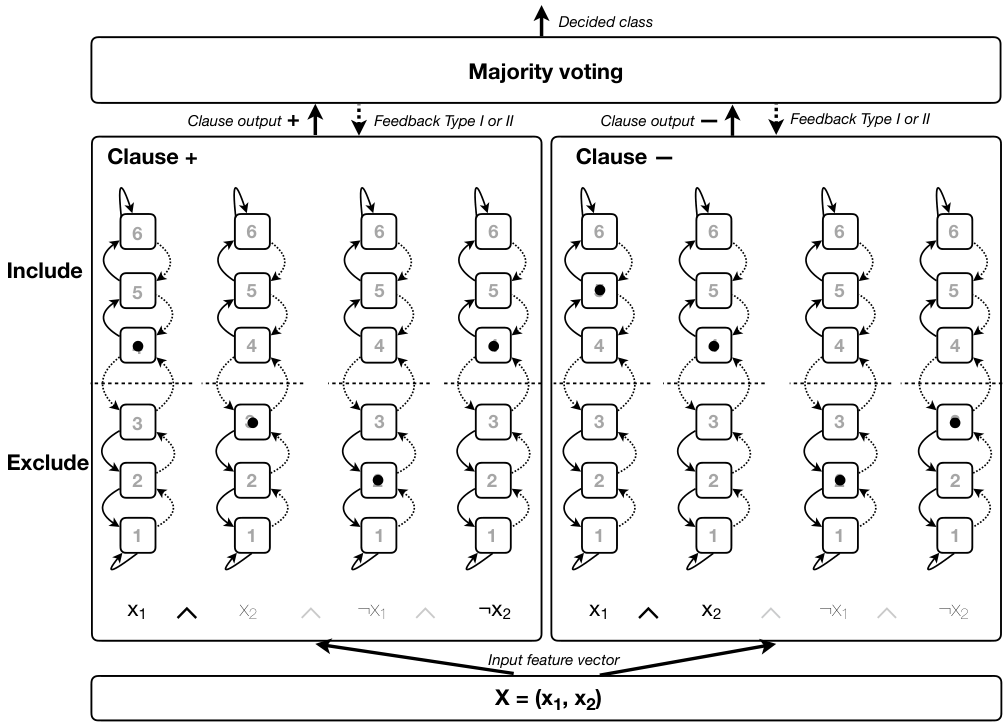

In [ ]:
from dataclasses import dataclass, field

import numpy as np
from numpy.typing import NDArray


@dataclass
class TsetlinClause:
    memory_size: int
    num_of_automata: int
    states: NDArray[np.int_] = field(init=False)

    def __post_init__(self) -> None:
        self.states = np.random.randint(1, 2*self.memory_size + 1, size=self.num_of_automata)


    def _clipped_step(self, step: NDArray[np.int_]) -> None:
        self.states = np.clip(self.states + step, 1, 2*self.memory_size)


    def _probability_vector(self, probability: float) -> NDArray[np.bool_]:
        return np.random.rand(self.num_of_automata) < probability


    def reset(self) -> None:
        self.states = np.zeros(self.num_of_automata, dtype=int) + self.memory_size


    def memorize(self, literals: NDArray[np.bool_], memorize_value: float) -> None:
        transition = literals & self._probability_vector(memorize_value)
        step = np.where(transition, 1, 0)
        self._clipped_step(step)


    def forget(self, literals: NDArray[np.bool_], forget_value: float) -> None:
        transition = literals & self._probability_vector(forget_value)
        step = np.where(transition, -1, 0)
        self._clipped_step(step)


    def get_actions(self) -> NDArray[np.bool_]:
        return self.states > self.memory_size


    def get_states(self) -> NDArray[np.int_]:
        return self.states.copy()


    def get_rule(self, features: list[str]) -> str:
        actions = self.get_actions()
        included = [f for action, f in zip(actions, features) if action]
        return " ∧ ".join(included) if included else "⊤"


    def condition(self, observation: NDArray[np.bool_]) -> tuple[np.bool_, NDArray[np.bool_]]:
        mem_literals = self.states > self.memory_size
        true_literals = observation & mem_literals
        return np.all(true_literals[mem_literals]), true_literals


    def vote(self, observation: NDArray[np.bool_]) -> int:
        fired, _ = self.condition(observation)
        return 1 if fired else 0


    def type_i_feedback(self, observation: NDArray[np.bool_], memorize_value: float) -> None:
        forget_value = 1 - memorize_value
        condition, true_literals = self.condition(observation)
        if condition:
            self.memorize(true_literals, memorize_value)
            self.forget(~true_literals, forget_value)
        else:
            all_literals = np.ones(self.num_of_automata, dtype=bool)
            self.forget(all_literals, forget_value)


    # Reject feedback
    def type_ii_feedback(self, observation: NDArray[np.bool_]) -> None:
        condition, true_literals = self.condition(observation)
        if condition:
            memorize_literals = ~true_literals & (self.states <= self.memory_size)
            self.memorize(memorize_literals, 1.0)
